In [1]:
import collections
import os
import random
import tarfile
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import csv
import sys
import math
import time
import json
import zipfile
from tqdm import tqdm
from PIL import Image
from collections import namedtuple
from IPython import display
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchtext
import numpy as np
from itertools import chain
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torch.autograd as autograd
import torchtext.vocab as torchvocab
from torch.autograd import Variable
import tqdm
import os
import time
import re
import pandas as pd
import string
import gensim
import time
import random
import snowballstemmer
import collections
from collections import Counter
from nltk.corpus import stopwords
from itertools import chain
from sklearn.metrics import accuracy_score



sys.path.append("..") 

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_ROOT = "/Users/shuxialin/Documents/project/code"

In [2]:
fname = os.path.join(DATA_ROOT, "aclImdb_v1.tar.gz")
if not os.path.exists(os.path.join(DATA_ROOT, "aclImdb")):
    print("从压缩包解压...")
    with tarfile.open(fname, 'r') as f:
        f.extractall(DATA_ROOT)

In [3]:
sentences = []
lines = []
with open("/Users/shuxialin/Documents/flip/01and03/data/se07_test.xml", 'r') as fileobj :
    for line in fileobj :
        lines.append(line)
        
lines = lines[1:]

for line in lines :
    tokens = (line.split('<')[1]).split('>')
    sentences.append(tokens[-1])

sen_se07 = sentences[:1000]

se07_classes = []

with open('/Users/shuxialin/Documents/flip/01and03/data/se07_test.emotions.gold', 'r') as flie :
    for line in flie:
        token = (line.split())[1:]
        a = token.index(max(token))
        se07_classes.append(a)
        
train_data = []
test_data = [] 

for i in range(800):
    train_data.append([sen_se07[i],se07_classes[i]])
for i in range(200):
    test_data.append([sen_se07[i+800],se07_classes[i+800]])

In [4]:
def get_tokenized_imdb(data):
    """
    data: list of [string, label]
    """
    def tokenizer(text):
        return [tok.lower() for tok in text.split(' ')]
    return [tokenizer(review) for review, _   in data]

In [5]:
def get_vocab_imdb(data):
    tokenized_data = get_tokenized_imdb(data)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return Vocab.Vocab(counter, min_freq=2)

vocab = get_vocab_imdb(train_data)
'# words in vocab:', len(vocab)

('# words in vocab:', 812)

In [6]:
def preprocess_imdb(data, vocab):
    max_l = 100  # 将每条评论通过截断或者补0，使得长度变成500

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = get_tokenized_imdb(data)
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

In [7]:
batch_size = 64
preprocess_imdb(train_data, vocab)
train_set = Data.TensorDataset(*preprocess_imdb(train_data, vocab))
test_set = Data.TensorDataset(*preprocess_imdb(test_data, vocab))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

In [8]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 bidirectional, labels, use_gpu, **kwargs):
        super(SentimentNet, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.use_gpu = use_gpu
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.embedding.weight.requires_grad = False
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0)
        if self.bidirectional:
            self.decoder = nn.Linear(num_hiddens * 4, labels)
        else:
            self.decoder = nn.Linear(num_hiddens * 2, labels)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
        encoding = torch.cat([states[0], states[-1]], dim=1)
        outputs = self.decoder(encoding)
        return outputs

In [9]:
num_epochs = 80
embed_size = 300
num_hiddens = 100
num_layers = 2
bidirectional = True
batch_size = 64
labels = 6
lr = 0.001
#device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = True

net = SentimentNet(vocab_size=(len(vocab)+1), embed_size=embed_size,
                   num_hiddens=num_hiddens, num_layers=num_layers,
                   bidirectional=bidirectional,
                   labels=labels, use_gpu=use_gpu)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

In [11]:
glove_vocab = Vocab.GloVe(name='6B', dim=300, cache=os.path.join(DATA_ROOT, "glove"))

def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0]) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 0
    if oov_count > 0:
        print("There are %d oov words.")
    return embed

net.embedding.weight.data.copy_(
    load_pretrained_embedding(vocab.itos, glove_vocab))
net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它


In [12]:
result = []
loss_all = []
acc_all = []
loss_test = []
acc_test = []
for epoch in range(num_epochs):
    start = time.time()
    train_loss, test_losses = 0, 0
    train_acc, test_acc = 0, 0
    
    n, m = 0, 0
    for feature, label in train_iter:
        n += 1
        net.zero_grad()
        feature = Variable(feature)
        label = Variable(label)
        score = net(feature)
        loss = loss_function(score, label)
        #loss = nn.CrossEntropyLoss()
        loss.backward()
        optimizer.step()
        train_acc += accuracy_score(torch.argmax(score.cpu().data,
                                                 dim=1), label.cpu())
        train_loss += loss.cpu().item()
    with torch.no_grad():
        for test_feature, test_label in test_iter:
            m += 1
            test_feature = test_feature
            test_label = test_label
            test_score = net(test_feature)
            result.append(test_score)
            test_loss = loss_function(test_score, test_label)
            test_acc += accuracy_score(torch.argmax(test_score.cpu().data,
                                                    dim=1), test_label.cpu())
            test_losses += test_loss
    end = time.time()
    runtime = end - start
    loss_all.append(train_loss / n)
    acc_all.append(train_acc / n)
    loss_test.append(test_losses.data / m)
    acc_test.append(test_acc / m)
    print('epoch: %d, train loss: %.4f, train acc: %.2f, test loss: %.4f, test acc: %.2f, time: %.2f' %
          (epoch, train_loss / n, train_acc / n, test_losses.data / m, test_acc / m, runtime))



epoch: 0, train loss: 1.7897, train acc: 0.19, test loss: 1.7952, test acc: 0.12, time: 8.84
epoch: 1, train loss: 1.7894, train acc: 0.18, test loss: 1.7948, test acc: 0.12, time: 8.56
epoch: 2, train loss: 1.7893, train acc: 0.18, test loss: 1.7945, test acc: 0.12, time: 8.44
epoch: 3, train loss: 1.7882, train acc: 0.18, test loss: 1.7941, test acc: 0.12, time: 8.56
epoch: 4, train loss: 1.7881, train acc: 0.18, test loss: 1.7938, test acc: 0.12, time: 8.56
epoch: 5, train loss: 1.7873, train acc: 0.18, test loss: 1.7934, test acc: 0.12, time: 9.15
epoch: 6, train loss: 1.7872, train acc: 0.18, test loss: 1.7931, test acc: 0.12, time: 8.74
epoch: 7, train loss: 1.7864, train acc: 0.19, test loss: 1.7927, test acc: 0.12, time: 8.61
epoch: 8, train loss: 1.7871, train acc: 0.18, test loss: 1.7924, test acc: 0.12, time: 8.40
epoch: 9, train loss: 1.7855, train acc: 0.18, test loss: 1.7920, test acc: 0.12, time: 8.52
epoch: 10, train loss: 1.7852, train acc: 0.18, test loss: 1.7917, tes

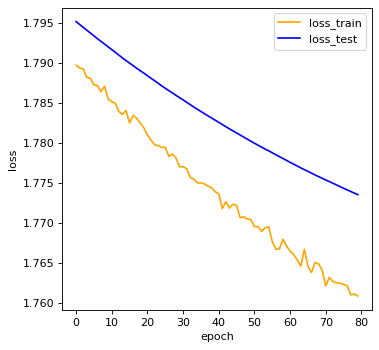

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x =[i for i in range(80)]

plt.figure(figsize=(5,5),dpi=80)

plt.plot(x,loss_all,label="loss_train",color="orange")
plt.plot(x,loss_test,label="loss_test",color="blue")
 
#设置x轴刻度
plt.xlabel('epoch') #X轴标签
plt.ylabel("loss") #Y轴标签
# plt.yticks(range(0,9)
plt.legend()
 
#plt.legend(handles=[A,B],labels=["train","test"])
 
plt.show()
plt.savefig("LSTM_loss.png", dpi=600)

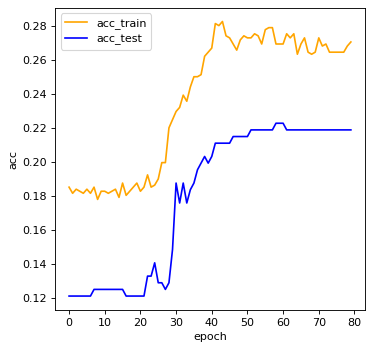

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import numpy as np

x =[i for i in range(80)]

plt.figure(figsize=(5,5),dpi=80)

plt.plot(x,acc_all,label="acc_train",color="orange")
plt.plot(x,acc_test,label="acc_test",color="blue")
 
#设置x轴刻度
plt.xlabel('epoch') #X轴标签
plt.ylabel("acc") #Y轴标签
# plt.yticks(range(0,9)
plt.legend()
 
#plt.legend(handles=[A,B],labels=["train","test"])
 
plt.show()
plt.savefig("LSTM_acc.png", dpi=600)

In [15]:
print(max(acc_all))
print(max(acc_test))
print(min(loss_all))
print(min(loss_test))

0.2824519230769231
0.22265625
1.7608467157070453
tensor(1.7735)
